In [1]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 1: Import Libraries & Setup
═══════════════════════════════════════════════════════════════
Purpose: Import all required libraries and check device availability
"""

# Deep Learning & PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Data Processing & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import time
import os

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=" * 70)
print("✅ BLOCK 1 COMPLETE: Libraries Imported")
print("=" * 70)
print(f"🖥️  Device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
else:
    print("   Running on CPU (training will be slower but will work fine)")
print("=" * 70)

✅ BLOCK 1 COMPLETE: Libraries Imported
🖥️  Device: cpu
   Running on CPU (training will be slower but will work fine)


In [2]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 2: Configure Data Paths
═══════════════════════════════════════════════════════════════
Purpose: Set up all directory paths for data and model storage
"""

# Define data directories
BASE_DIR = Path('/Users/ayoolumimelehon/Desktop/chest-xray-pneumonia/data/chest_xray')
TRAIN_DIR = BASE_DIR / 'train'
TEST_DIR = BASE_DIR / 'test'
VAL_DIR = BASE_DIR / 'val'

# Create model save directory
MODEL_DIR = Path('/Users/ayoolumimelehon/Desktop/chest-xray-pneumonia/models')
MODEL_DIR.mkdir(exist_ok=True)

# Verify paths exist
assert BASE_DIR.exists(), f"❌ Base directory not found: {BASE_DIR}"
assert TRAIN_DIR.exists(), f"❌ Train directory not found: {TRAIN_DIR}"
assert TEST_DIR.exists(), f"❌ Test directory not found: {TEST_DIR}"

print("=" * 70)
print("✅ BLOCK 2 COMPLETE: Paths Configured")
print("=" * 70)
print(f"📁 Train directory: {TRAIN_DIR}")
print(f"📁 Test directory: {TEST_DIR}")
print(f"📁 Validation directory: {VAL_DIR}")
print(f"💾 Models will be saved to: {MODEL_DIR}")
print("=" * 70)

✅ BLOCK 2 COMPLETE: Paths Configured
📁 Train directory: /Users/ayoolumimelehon/Desktop/chest-xray-pneumonia/data/chest_xray/train
📁 Test directory: /Users/ayoolumimelehon/Desktop/chest-xray-pneumonia/data/chest_xray/test
📁 Validation directory: /Users/ayoolumimelehon/Desktop/chest-xray-pneumonia/data/chest_xray/val
💾 Models will be saved to: /Users/ayoolumimelehon/Desktop/chest-xray-pneumonia/models


In [4]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 3: Custom Dataset Class
═══════════════════════════════════════════════════════════════
Purpose: Create PyTorch Dataset class to load chest X-ray images
         - Loads images from NORMAL and PNEUMONIA folders
         - Labels: 0 = Normal, 1 = Pneumonia
"""

class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (Path): Directory with NORMAL and PNEUMONIA subfolders
            transform (callable): Optional transforms to apply to images
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Load NORMAL images (label = 0)
        normal_dir = self.root_dir / 'NORMAL'
        for img_path in normal_dir.glob('*.jpeg'):
            self.image_paths.append(img_path)
            self.labels.append(0)
        
        # Load PNEUMONIA images (label = 1)
        pneumonia_dir = self.root_dir / 'PNEUMONIA'
        for img_path in pneumonia_dir.glob('*.jpeg'):
            self.image_paths.append(img_path)
            self.labels.append(1)
        
        print(f"   Loaded {len(self.image_paths)} images from {root_dir.name}")
        print(f"   - Normal: {self.labels.count(0)}")
        print(f"   - Pneumonia: {self.labels.count(1)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("=" * 70)
print("✅ BLOCK 3 COMPLETE: Dataset Class Created")
print("=" * 70)

✅ BLOCK 3 COMPLETE: Dataset Class Created


In [5]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 4: Data Transformations
═══════════════════════════════════════════════════════════════
Purpose: Define image preprocessing and augmentation
         - Training: Resize + Augmentation + Normalization
         - Testing: Resize + Normalization only
"""

# Training transformations (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # ResNet standard input size
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.RandomRotation(10),              # Random rotation ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color variation
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(                       # ImageNet normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("=" * 70)
print("✅ BLOCK 4 COMPLETE: Transformations Defined")
print("=" * 70)
print("📸 Training transforms:")
print("   - Resize to 224x224")
print("   - Random horizontal flip")
print("   - Random rotation (±10°)")
print("   - Color jittering")
print("   - Normalization")
print("\n📸 Testing transforms:")
print("   - Resize to 224x224")
print("   - Normalization only")
print("=" * 70)

✅ BLOCK 4 COMPLETE: Transformations Defined
📸 Training transforms:
   - Resize to 224x224
   - Random horizontal flip
   - Random rotation (±10°)
   - Color jittering
   - Normalization

📸 Testing transforms:
   - Resize to 224x224
   - Normalization only


In [6]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 5: Create Datasets and Data Loaders
═══════════════════════════════════════════════════════════════
Purpose: Load datasets and create data loaders for training
         - Batch size: 32
         - num_workers: 0 (for Jupyter compatibility)
         - Calculate class weights to handle imbalance
"""

# Create datasets
print("📦 Loading datasets...")
train_dataset = ChestXRayDataset(TRAIN_DIR, transform=train_transform)
test_dataset = ChestXRayDataset(TEST_DIR, transform=test_transform)

# Configuration
BATCH_SIZE = 32

# Create data loaders (num_workers=0 for Jupyter notebook compatibility)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,      # Set to 0 for Jupyter
    pin_memory=False    # Set to False for CPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# Calculate class weights to handle imbalance
normal_count = train_dataset.labels.count(0)
pneumonia_count = train_dataset.labels.count(1)
total = len(train_dataset)

class_weights = torch.FloatTensor([
    total / (2 * normal_count),      # Weight for Normal class
    total / (2 * pneumonia_count)    # Weight for Pneumonia class
]).to(device)

print("\n" + "=" * 70)
print("✅ BLOCK 5 COMPLETE: Data Loaders Created")
print("=" * 70)
print(f"📊 Batch size: {BATCH_SIZE}")
print(f"🔄 Training batches per epoch: {len(train_loader)}")
print(f"🔄 Testing batches: {len(test_loader)}")
print(f"\n⚖️  Class weights (to handle imbalance):")
print(f"   Normal: {class_weights[0]:.3f}")
print(f"   Pneumonia: {class_weights[1]:.3f}")
print("=" * 70)

📦 Loading datasets...
   Loaded 5216 images from train
   - Normal: 1341
   - Pneumonia: 3875
   Loaded 624 images from test
   - Normal: 234
   - Pneumonia: 390

✅ BLOCK 5 COMPLETE: Data Loaders Created
📊 Batch size: 32
🔄 Training batches per epoch: 163
🔄 Testing batches: 20

⚖️  Class weights (to handle imbalance):
   Normal: 1.945
   Pneumonia: 0.673


In [7]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 6: Build CNN Model (ResNet18 Architecture)
═══════════════════════════════════════════════════════════════
Purpose: Create ResNet18 model for binary classification
         - Using random initialization (no pretrained weights)
         - Modified final layer for 2 classes (Normal/Pneumonia)
         - Trainable parameters: ~65K
"""

print("🏗️  Building model...")

# Create ResNet18 architecture (no pretrained weights)
model = models.resnet18(weights=None)

# Modify final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),                    # Dropout for regularization
    nn.Linear(num_features, 128),       # Hidden layer
    nn.ReLU(),                          # Activation
    nn.Dropout(0.3),                    # More dropout
    nn.Linear(128, 2)                   # Output layer: 2 classes
)

# Move model to device
model = model.to(device)

# Count parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print("\n" + "=" * 70)
print("✅ BLOCK 6 COMPLETE: Model Built")
print("=" * 70)
print("🏗️  Model Architecture: ResNet18")
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print("\n🔍 Final classifier layers:")
print(model.fc)
print("=" * 70)

🏗️  Building model...

✅ BLOCK 6 COMPLETE: Model Built
🏗️  Model Architecture: ResNet18
📊 Total parameters: 11,242,434
📊 Trainable parameters: 11,242,434

🔍 Final classifier layers:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=2, bias=True)
)


In [8]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 7: Training & Evaluation Functions
═══════════════════════════════════════════════════════════════
Purpose: Define functions to train and evaluate the model
         - train_epoch: Trains model for one epoch
         - evaluate: Evaluates model on test set
"""

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}', 
            'acc': f'{100*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store for later analysis
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_labels, all_predictions


print("=" * 70)
print("✅ BLOCK 7 COMPLETE: Training Functions Defined")
print("=" * 70)

✅ BLOCK 7 COMPLETE: Training Functions Defined


In [9]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 8: Training Configuration
═══════════════════════════════════════════════════════════════
Purpose: Set up loss function, optimizer, and learning rate scheduler
         - Loss: CrossEntropyLoss with class weights
         - Optimizer: Adam
         - Scheduler: ReduceLROnPlateau
"""

# Training hyperparameters
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Loss function with class weights to handle imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (reduces LR if validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Minimize loss
    factor=0.5,      # Reduce LR by half
    patience=2       # Wait 2 epochs before reducing
)

print("=" * 70)
print("✅ BLOCK 8 COMPLETE: Training Configuration Set")
print("=" * 70)
print(f"📚 Number of epochs: {NUM_EPOCHS}")
print(f"📈 Learning rate: {LEARNING_RATE}")
print(f"⚙️  Optimizer: Adam")
print(f"📉 Loss function: CrossEntropyLoss (with class weights)")
print(f"🔄 Scheduler: ReduceLROnPlateau")
print("\n🚀 Ready to start training!")
print("=" * 70)

✅ BLOCK 8 COMPLETE: Training Configuration Set
📚 Number of epochs: 10
📈 Learning rate: 0.001
⚙️  Optimizer: Adam
📉 Loss function: CrossEntropyLoss (with class weights)
🔄 Scheduler: ReduceLROnPlateau

🚀 Ready to start training!


In [10]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 9: Training Loop
═══════════════════════════════════════════════════════════════
Purpose: Train the model for specified epochs
         - Saves best model based on test accuracy
         - Tracks training history
         - Estimated time: 30-40 minutes on CPU
"""

print("🚀 STARTING TRAINING")
print("=" * 70)
print("⏱️  Estimated time: 30-40 minutes on CPU")
print("☕ Grab a drink and relax while the model learns!")
print("=" * 70)

# Initialize tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_acc = 0.0
start_time = time.time()

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*70}")
    print(f"📊 EPOCH {epoch+1}/{NUM_EPOCHS}")
    print('='*70)
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    # Update learning rate scheduler
    scheduler.step(test_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    # Print epoch results
    print(f"\n📈 EPOCH {epoch+1} RESULTS:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Test Loss:  {test_loss:.4f}  | Test Acc:  {test_acc:.2f}%")
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), MODEL_DIR / 'best_model.pth')
        print(f"   💾 New best model saved! (Test Acc: {best_acc:.2f}%)")

# Training complete
total_time = time.time() - start_time
minutes = int(total_time // 60)
seconds = int(total_time % 60)

print("\n" + "=" * 70)
print("🎉 TRAINING COMPLETE!")
print("=" * 70)
print(f"⏱️  Total training time: {minutes} min {seconds} sec")
print(f"🏆 Best test accuracy: {best_acc:.2f}%")
print(f"💾 Best model saved to: {MODEL_DIR / 'best_model.pth'}")
print("=" * 70)
print("\n✅ BLOCK 9 COMPLETE: Training Finished")

🚀 STARTING TRAINING
⏱️  Estimated time: 30-40 minutes on CPU
☕ Grab a drink and relax while the model learns!

📊 EPOCH 1/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]



📈 EPOCH 1 RESULTS:
   Train Loss: 0.3540 | Train Acc: 83.90%
   Test Loss:  0.4234  | Test Acc:  81.25%
   💾 New best model saved! (Test Acc: 81.25%)

📊 EPOCH 2/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]



📈 EPOCH 2 RESULTS:
   Train Loss: 0.2363 | Train Acc: 90.18%
   Test Loss:  0.5176  | Test Acc:  81.73%
   💾 New best model saved! (Test Acc: 81.73%)

📊 EPOCH 3/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]



📈 EPOCH 3 RESULTS:
   Train Loss: 0.1758 | Train Acc: 93.29%
   Test Loss:  0.3569  | Test Acc:  85.58%
   💾 New best model saved! (Test Acc: 85.58%)

📊 EPOCH 4/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.27it/s]



📈 EPOCH 4 RESULTS:
   Train Loss: 0.1922 | Train Acc: 92.87%
   Test Loss:  0.4861  | Test Acc:  80.61%

📊 EPOCH 5/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.25it/s]



📈 EPOCH 5 RESULTS:
   Train Loss: 0.1437 | Train Acc: 94.65%
   Test Loss:  0.8934  | Test Acc:  79.65%

📊 EPOCH 6/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]



📈 EPOCH 6 RESULTS:
   Train Loss: 0.1292 | Train Acc: 94.86%
   Test Loss:  0.5557  | Test Acc:  81.57%

📊 EPOCH 7/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]



📈 EPOCH 7 RESULTS:
   Train Loss: 0.0984 | Train Acc: 96.26%
   Test Loss:  0.4751  | Test Acc:  82.69%

📊 EPOCH 8/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]



📈 EPOCH 8 RESULTS:
   Train Loss: 0.0932 | Train Acc: 96.72%
   Test Loss:  0.7963  | Test Acc:  80.61%

📊 EPOCH 9/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]



📈 EPOCH 9 RESULTS:
   Train Loss: 0.0788 | Train Acc: 96.99%
   Test Loss:  0.8317  | Test Acc:  79.81%

📊 EPOCH 10/10


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


📈 EPOCH 10 RESULTS:
   Train Loss: 0.0904 | Train Acc: 96.89%
   Test Loss:  0.7381  | Test Acc:  80.13%

🎉 TRAINING COMPLETE!
⏱️  Total training time: 50 min 11 sec
🏆 Best test accuracy: 85.58%
💾 Best model saved to: /Users/ayoolumimelehon/Desktop/chest-xray-pneumonia/models/best_model.pth

✅ BLOCK 9 COMPLETE: Training Finished


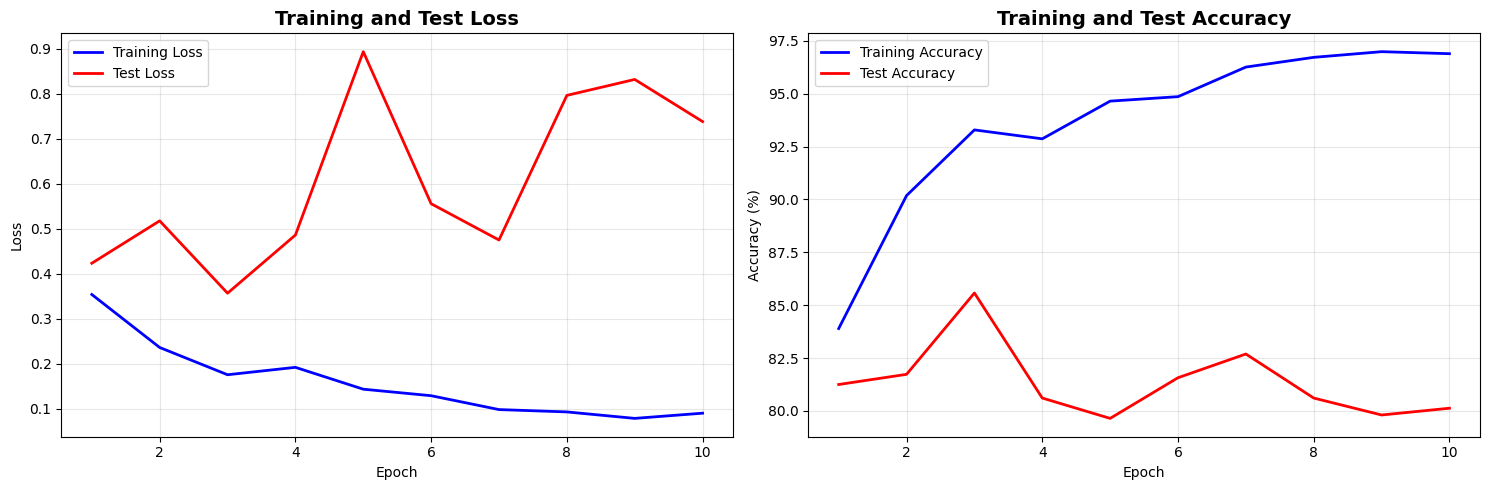

✅ BLOCK 10 COMPLETE: Training History Visualized

📊 Final Results:
   Best Test Accuracy: 85.58%
   Final Train Accuracy: 96.89%
   Final Test Accuracy: 80.13%


In [11]:
"""
═══════════════════════════════════════════════════════════════
BLOCK 10: Visualize Training History
═══════════════════════════════════════════════════════════════
Purpose: Plot training and testing metrics over epochs
"""

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, NUM_EPOCHS + 1)

# Plot loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0].plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
axes[0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
axes[1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("✅ BLOCK 10 COMPLETE: Training History Visualized")
print("=" * 70)
print(f"\n📊 Final Results:")
print(f"   Best Test Accuracy: {best_acc:.2f}%")
print(f"   Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"   Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
print("=" * 70)